In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
trnsf = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
}

In [5]:
ds_train = datasets.MNIST(root='.', train=True, transform=trnsf['train'], download=True)
ds_train = Subset(ds_train, list(range(80)))

ds_eval = datasets.MNIST(root='.', train=False, transform=trnsf['test'], download=True)
ds_eval = Subset(ds_eval, list(range(20)))

/home/tobias/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def imshow(im: torch.Tensor):
    im = im * 0.5 + 0.5
    im_np = im.numpy()
    im_np = im_np.transpose([1, 2, 0])
    plt.axis('off')
    plt.imshow(im_np, cmap='gray')

target: 2


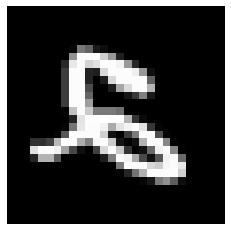

In [7]:
import random

# show a random image
idx = random.randint(0, len(ds_train))
x = ds_train[idx]

imshow(x[0])
print(f"target: {x[1]}")

In [8]:
n_classes = len(torch.unique(ds_train.dataset.targets).tolist())

In [13]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, n_classes)

In [14]:
from lib.data import LabelSmoothingLoss

optimizer = optim.Adam(model.parameters())
criterion = LabelSmoothingLoss(n_classes, confidence=0.9)

In [15]:
from lib.trainer import TrainerConfig, Trainer
from lib.metrics import AccuracyCallback
from lib.callbacks import EarlyStoppingCallback
from lib.torch_utils import set_seed

set_seed(1337)

config = TrainerConfig(
    batch_size=32, 
    epochs=50
)
trainer = Trainer(
    config, 
    model, 
    optimizer, 
    ds_train, 
    ds_eval,
    loss_fn=criterion,
    callbacks=[AccuracyCallback(monitor=True), EarlyStoppingCallback(max_epochs_no_change=5)]
)

In [16]:
trainer.train()

100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
29/08/2021 00:09:39 - lib.trainer - INFO - epoch 0 - train_loss: 2.0899. 
29/08/2021 00:09:39 - lib.callbacks - INFO - New best score - accuracy: 0.1500
29/08/2021 00:09:39 - lib.trainer - INFO - epoch 0 - eval_loss: 2.3452. accuracy: 0.1500. 
100%|██████████| 3/3 [00:01<00:00,  1.90it/s]
29/08/2021 00:09:41 - lib.trainer - INFO - epoch 1 - train_loss: 1.3334. 
29/08/2021 00:09:41 - lib.callbacks - INFO - New best score - accuracy: 0.4500
29/08/2021 00:09:41 - lib.trainer - INFO - epoch 1 - eval_loss: 2.0372. accuracy: 0.4500. 
100%|██████████| 3/3 [00:01<00:00,  1.86it/s]
29/08/2021 00:09:43 - lib.trainer - INFO - epoch 2 - train_loss: 1.2245. 
29/08/2021 00:09:43 - lib.trainer - INFO - epoch 2 - eval_loss: 1.8608. accuracy: 0.4000. 
100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
29/08/2021 00:09:44 - lib.trainer - INFO - epoch 3 - train_loss: 1.2125. 
29/08/2021 00:09:44 - lib.callbacks - INFO - New best score - accuracy: 0.5000
29/08/2021